# Homework 2 - Data cleaning & Text representation 

### Importing useful libraries 

In [1]:
# Data manipulation
import numpy as np 
import pandas as pd 
from PIL import Image
import pandas_profiling

# Text manipulation
from string import punctuation
#from stop_words import get_stop_words
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

# NLP Module
import nltk
from nltk import word_tokenize
from nltk import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

## Downloading useful nltk packages 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Extra imports
import seaborn as sns
import matplotlib as plt
from collections import Counter
from itertools import chain 
import jl_to_df

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Abderrahmane/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/Abderrahmane/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/Abderrahmane/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Hands on 1 - EDA, Cleaning, Tokenization & Feature Engineering

## a) Loading Data

In [44]:
# Path of folders where data are stored
DATA_PATH = "data/"
FIG_PATH = "fig/"

# Try to name your data / dataframe explicitly. 
file_name = "Bokan_37.csv"
file_path = DATA_PATH + file_name

# Reading data
scrapped_data = pd.read_csv(file_path)


#scrapped_data = jl_to_df.read_jl_file(DATA_PATH+'Cinnamon.jl')

## b) Exploratory Data Analysis

In [45]:
# Looking at a sample of the data
scrapped_data.head()

,Unnamed: 0,answer_text,content,diner_date,id_comment,id_resto,other_ratings_category,other_ratings_value,rating,rating_date,resto,resto_url,reviewer_info_sup,reviewer_origin,reviewer_pseudo,title,url
0,0,['Thank you so much Eutalika for your amazing ...,"[""Highly recommend the food! The most amazing ...",February 2020,g186338-d12156905-r746568155,g186338-d12156905,[],[],5,21 February 2020,Bokan_37_Restaurant,/Restaurant_Review-g186338-d12156905-Reviews-B...,"[['pencil-paper', '1']]","['Canterbury, United Kingdom']",eutalika,Amazing food,https://www.tripadvisor.co.uk/ShowUserReviews-...
1,1,"['Wow Jean Yves, your review is amazing. We ju...","['Whaou ', 'It’s really really good, ', 'We’re...",January 2020,g186338-d12156905-r739899453,g186338-d12156905,[],[],5,18 January 2020,Bokan_37_Restaurant,/Restaurant_Review-g186338-d12156905-Reviews-B...,"[['pencil-paper', '11'], ['thumbs-up-fill', '6']]","['Golfe-Juan Vallauris, France']",JeanyvesTov,MAGNIFIQUE,https://www.tripadvisor.co.uk/ShowUserReviews-...
2,2,['Thank you Kevin T for sharing your experienc...,['We were on site so decided to visit. We shar...,January 2020,g186338-d12156905-r741474592,g186338-d12156905,[],[],2,27 January 2020,Bokan_37_Restaurant,/Restaurant_Review-g186338-d12156905-Reviews-B...,"[['pencil-paper', '528'], ['thumbs-up-fill', '...","['Auckland, New Zealand']",satanbug,Much better out there......,https://www.tripadvisor.co.uk/ShowUserReviews-...
3,3,['Thank you so much Maylis N for this fabulous...,"[""My brother and I went to Bokan for dinner la...",January 2020,g186338-d12156905-r738963228,g186338-d12156905,[],[],5,13 January 2020,Bokan_37_Restaurant,/Restaurant_Review-g186338-d12156905-Reviews-B...,"[['pencil-paper', '1']]",[],maylisn2020,A wonder,https://www.tripadvisor.co.uk/ShowUserReviews-...
4,4,['Thank you so much Justine R for this beautif...,['We went to dinner with my partner in this re...,January 2020,g186338-d12156905-r739999991,g186338-d12156905,[],[],5,19 January 2020,Bokan_37_Restaurant,/Restaurant_Review-g186338-d12156905-Reviews-B...,"[['pencil-paper', '1']]",[],justine-royer85,Beautiful as Well as good,https://www.tripadvisor.co.uk/ShowUserReviews-...


In [46]:
# Detecting missing values
scrapped_data.isna().sum()

Unnamed: 0                 0
answer_text               14
content                    0
diner_date                19
id_comment                 0
id_resto                   0
other_ratings_category     0
other_ratings_value        0
rating                     0
rating_date                0
resto                      0
resto_url                  0
reviewer_info_sup          0
reviewer_origin            0
reviewer_pseudo            0
title                      0
url                        0
dtype: int64

In [47]:
# Generate profile report for quick data analysis
# scrapped_data.profile_report()

#### Comments on dataframe profile report

**1. Overview & Missing values**
- We are working on a sample of **5000 observations** and we have **17 variables** in the dataframe
- The only two variables having missing values are **answer_text** and **diner_date**. We see that almost 80% of the reviews were left without an answer which is normal because restaurant owners can't answer all rewiews. Also around 5% of the rewiers forgot to mention their diner date
    
**2. Variables**

The most important variable here is **rating**, it has a mean of around 4 and we see that most reviewers issue high ratings of 5 or 4 as opposed to 1, 2 or 3 which can be explained by the fact that people's tendency to issue good reviews for the restaurants they like is higher than their tendency to issue bad reviews for the restaurants they don't like.

**3. Correlations**

We can't say much about correlations from profile report. No immediate correlation can be observed between rating and other features.

## c) Basic review cleaning, Tokenization & Feature engineering

###  - Cleaning

In [48]:
# Defining basic cleaning function

def basic_cleaning(series):
    # Remove punctuation
    new_series = series.str.replace('[^\w\s]','')
    # Strip trailing whitespace
    new_series = new_series.str.strip(" ")
    # Decapitalize letters
    new_series = new_series.apply(lambda x: str(x).lower())
    return new_series

scrapped_data['clean_title'] = basic_cleaning(scrapped_data['title'])
scrapped_data[['title','clean_title']].head() 

,title,clean_title
0,Amazing food,amazing food
1,MAGNIFIQUE,magnifique
2,Much better out there......,much better out there
3,A wonder,a wonder
4,Beautiful as Well as good,beautiful as well as good


### - Tokenization

In [49]:
# Defining tokenizing function

def tokenize_filter(sentence):
    # Define stopwords
    stop_words = set(stopwords.words('english')) 
    ## Add personalised stop words
    stop_words |= set(["london", "food", "drink", "restaurant"])
    # Filter the sentence
    word_tokens = word_tokenize(sentence) 
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    return (word_tokens, filtered_sentence) 

# Tokenizing the clean reviews without any stopwords 
scrapped_data["tokenized_title"] = scrapped_data["clean_title"].apply(lambda x: tokenize_filter(x)[1])
scrapped_data[["clean_title", "tokenized_title"]].head()

,clean_title,tokenized_title
0,amazing food,[amazing]
1,magnifique,[magnifique]
2,much better out there,"[much, better]"
3,a wonder,[wonder]
4,beautiful as well as good,"[beautiful, well, good]"


### - Feature Engineering

#### 1) Datetime format

In [50]:
scrapped_data["diner_date"] = pd.to_datetime(scrapped_data["diner_date"])
scrapped_data["rating_date"] = pd.to_datetime(scrapped_data["rating_date"])

#### 2) Review length

In [51]:
scrapped_data["title_len"] = scrapped_data.apply(lambda x: len(x["title"]), axis=1)

In [52]:
scrapped_data['len_review'] = scrapped_data['content'].apply(lambda x : len(x))

#### 3) Weekday

In [53]:
scrapped_data['day_of_week'] = scrapped_data.apply(lambda x: x["rating_date"].day, axis=1)

#### 4) Difference in days between rating and diner dates

In [54]:
scrapped_data["diner_rating_diff"] = scrapped_data.apply(lambda x: x["rating_date"] - x["diner_date"], axis=1)

In [55]:
scrapped_data.head()

,Unnamed: 0,answer_text,content,diner_date,id_comment,id_resto,other_ratings_category,other_ratings_value,rating,rating_date,...,reviewer_origin,reviewer_pseudo,title,url,clean_title,tokenized_title,title_len,len_review,day_of_week,diner_rating_diff
0,0,['Thank you so much Eutalika for your amazing ...,"[""Highly recommend the food! The most amazing ...",2020-02-01,g186338-d12156905-r746568155,g186338-d12156905,[],[],5,2020-02-21,...,"['Canterbury, United Kingdom']",eutalika,Amazing food,https://www.tripadvisor.co.uk/ShowUserReviews-...,amazing food,[amazing],12,226,21,20 days
1,1,"['Wow Jean Yves, your review is amazing. We ju...","['Whaou ', 'It’s really really good, ', 'We’re...",2020-01-01,g186338-d12156905-r739899453,g186338-d12156905,[],[],5,2020-01-18,...,"['Golfe-Juan Vallauris, France']",JeanyvesTov,MAGNIFIQUE,https://www.tripadvisor.co.uk/ShowUserReviews-...,magnifique,[magnifique],11,333,18,17 days
2,2,['Thank you Kevin T for sharing your experienc...,['We were on site so decided to visit. We shar...,2020-01-01,g186338-d12156905-r741474592,g186338-d12156905,[],[],2,2020-01-27,...,"['Auckland, New Zealand']",satanbug,Much better out there......,https://www.tripadvisor.co.uk/ShowUserReviews-...,much better out there,"[much, better]",27,449,27,26 days
3,3,['Thank you so much Maylis N for this fabulous...,"[""My brother and I went to Bokan for dinner la...",2020-01-01,g186338-d12156905-r738963228,g186338-d12156905,[],[],5,2020-01-13,...,[],maylisn2020,A wonder,https://www.tripadvisor.co.uk/ShowUserReviews-...,a wonder,[wonder],8,847,13,12 days
4,4,['Thank you so much Justine R for this beautif...,['We went to dinner with my partner in this re...,2020-01-01,g186338-d12156905-r739999991,g186338-d12156905,[],[],5,2020-01-19,...,[],justine-royer85,Beautiful as Well as good,https://www.tripadvisor.co.uk/ShowUserReviews-...,beautiful as well as good,"[beautiful, well, good]",26,304,19,18 days


## d) Some visualisations

In [56]:
cnt = scrapped_data["rating"].value_counts()

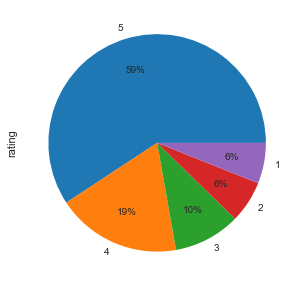

In [57]:
plot = cnt.plot.pie(y='rating', autopct='%1.0f%%', pctdistance=0.7, figsize=(5, 5))

#### 1) Most common words

In [58]:
reviews = scrapped_data["clean_title"].str.split()
most_frequent_words = Counter(chain(*reviews)).most_common()
most_frequent_words[:10]

[('food', 97),
 ('great', 97),
 ('view', 84),
 ('views', 81),
 ('service', 79),
 ('and', 70),
 ('amazing', 67),
 ('a', 54),
 ('with', 46),
 ('the', 42)]

#### 2) Worldcloud for the titles of our reviews

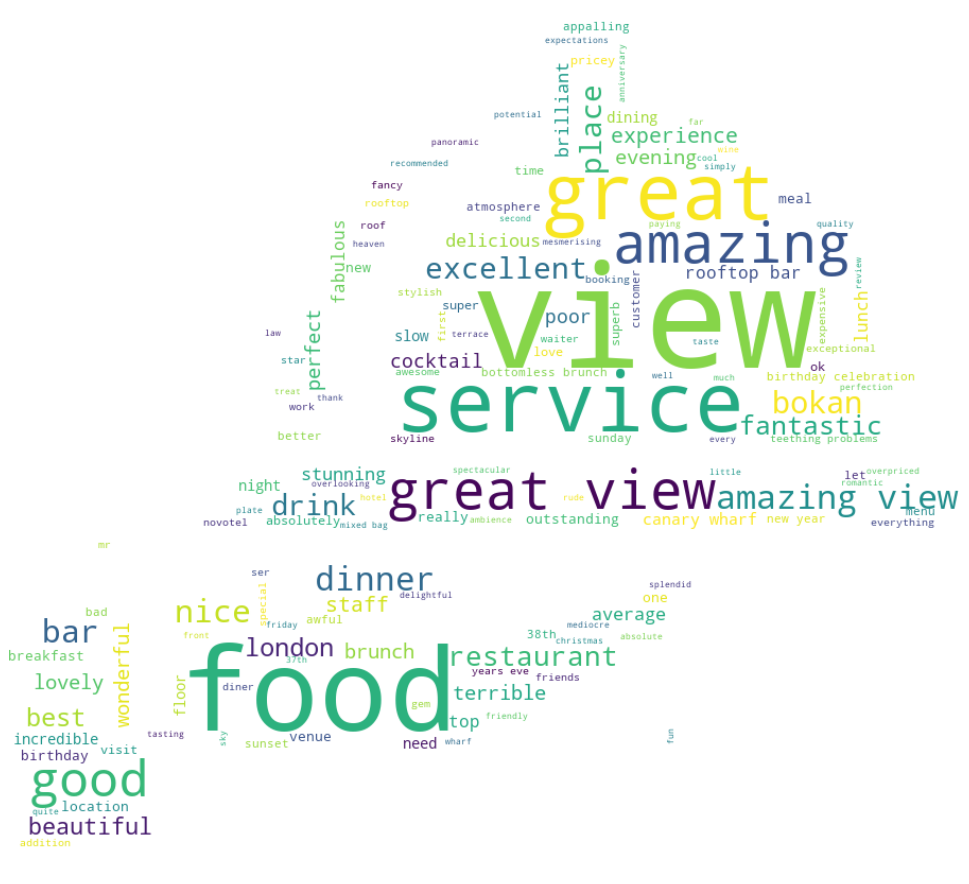

In [59]:
# Define masks for wordcloud
image = Image.open(FIG_PATH + "plate.jpg")
plate_mask = np.array(image)

image = Image.open(FIG_PATH + "waiter.jpg")
waiter_mask = np.array(image)

# Function to generate word cloud from corpusfrom_corpus_to_word_cloud(scrapped_data['clean_title'])
def from_corpus_to_word_cloud(text_column, mask):
    text_column = scrapped_data['clean_title']
    text_column = text_column.to_string()
    # Generate a word cloud image
    wc = WordCloud(background_color="white",min_font_size=7, mask=mask)
    # Setting max font size to 50 to display more words
    wordcloud = wc.generate(text_column)
    from matplotlib.pyplot import figure
    figure(num=None, figsize=(20, 16))
    #plt.pyplot.figure()
    plt.pyplot.imshow(wordcloud, interpolation="bilinear")
    plt.pyplot.axis("off")
    plt.pyplot.show() 
    return wordcloud



from_corpus_to_word_cloud(scrapped_data['clean_title'], waiter_mask)

#### 3) Review length association with ratings

####  Review Length Distribution

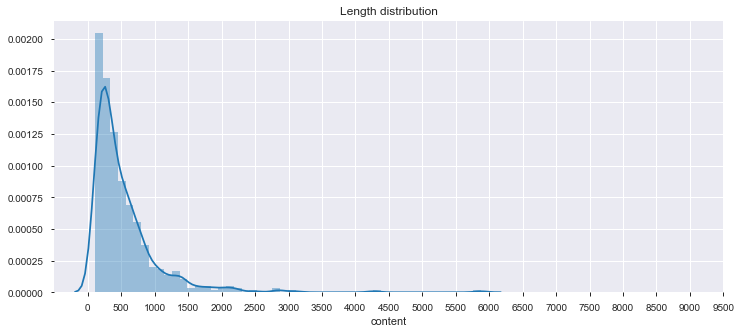

In [60]:
# Plot density with histogram
x = plt.pyplot.figure(figsize=(12,5))
sns.distplot(scrapped_data['content'].apply(len))
plt.pyplot.title('Length distribution')
plt.pyplot.xticks(range(0,10000,500))
plt.pyplot.show()

####  Average review length per rating:
Let's check the mean review length for each of the five possible ratings:

In [61]:
scrapped_data.groupby("rating").mean()["len_review"]

rating
1    1264.225806
2     902.312500
3     722.705882
4     517.063158
5     402.562500
Name: len_review, dtype: float64

#### Percentage of each rating per length review interval

In [62]:
# This method creates intervals for the length of the review
def review_size(len_review):
    if len_review < 100 :
        return '0-100'
    elif ((len_review >=100) and (len_review<500)):
        return '100-500'
    elif ((len_review >=500) and (len_review<1000)):
        return '500-1000'
    elif ((len_review >=1000) and (len_review<5000)):
        return '1000-5000'
    elif ((len_review >=5000) and (len_review<10000)):
        return '5000-10000'
    elif len_review >=10000 :
          return '>10000'
          
scrapped_data['len_review_interval'] = scrapped_data['len_review'].apply(lambda x : review_size(x) )
rating_per_length = scrapped_data[['len_review_interval', 'rating', 'content']]\
                        .groupby(by=['len_review_interval', 'rating'], as_index=False).count()

#Fill in 0 when the len_review_interval has no reviews for a certain rating
for size in rating_per_length['len_review_interval'].unique():
    for i in range(1, 6):
        length = len(rating_per_length)
        if len(rating_per_length[(rating_per_length['len_review_interval'] == size) & (rating_per_length['rating']==i)])==0:
            rating_per_length.loc[length+1] = [size, i, 0]

In [63]:
rating_1 = list(rating_per_length[rating_per_length['rating']==1].sort_values(by=['len_review_interval'])['content'])
rating_2 = list(rating_per_length[rating_per_length['rating']==2].sort_values(by=['len_review_interval'])['content'])
rating_3 = list(rating_per_length[rating_per_length['rating']==3].sort_values(by=['len_review_interval'])['content'])
rating_4 = list(rating_per_length[rating_per_length['rating']==4].sort_values(by=['len_review_interval'])['content'])
rating_5 = list(rating_per_length[rating_per_length['rating']==5].sort_values(by=['len_review_interval'])['content'])

df_ratings = pd.DataFrame(list(zip(rating_1, rating_2, rating_3,rating_4, rating_5)), 
                  columns =['rating_1', 'rating_2', 'rating_3', 'rating_4','rating_5']) 

# From raw value to percentage
totals = [i+j+k+l+m for i,j,k, l,m in zip( df_ratings['rating_1'], df_ratings['rating_2'], df_ratings['rating_3'], df_ratings['rating_4'],df_ratings['rating_5'])]
rate_1 = [i / j * 100 for i,j in zip(df_ratings['rating_1'], totals)]
rate_2 = [i / j * 100 for i,j in zip(df_ratings['rating_2'], totals)]
rate_3 = [i / j * 100 for i,j in zip(df_ratings['rating_3'], totals)]
rate_4 = [i / j * 100 for i,j in zip(df_ratings['rating_4'], totals)]
rate_5 = [i / j * 100 for i,j in zip(df_ratings['rating_5'], totals)]

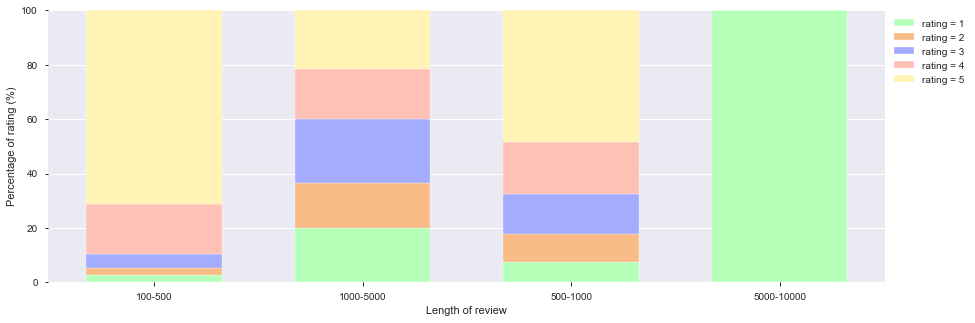

In [64]:
# plot
plt.pyplot.figure(figsize=(15,5))
r = list(range(0, len(rating_1)))
barWidth = 0.65
names = rating_per_length['len_review_interval'].unique()
plt.pyplot.bar(r, rate_1 , color='#b5ffb9', edgecolor='white', width=barWidth, label='rating = 1')
plt.pyplot.bar(r, rate_2, bottom=rate_1, color='#f9bc86', edgecolor='white', width=barWidth, label='rating = 2')
plt.pyplot.bar(r, rate_3, bottom=[i+j for i,j in zip(rate_1, rate_2)], color='#a3acff', edgecolor='white', width=barWidth, label='rating = 3')
plt.pyplot.bar(r, rate_4, bottom=[i+j+k for i,j,k in zip(rate_1, rate_2, rate_3)], color='#ffc0b5', edgecolor='white', width=barWidth, label='rating = 4')
plt.pyplot.bar(r, rate_5, bottom=[i+j+k+l for i,j,k,l in zip(rate_1, rate_2, rate_3, rate_4)], color='#fff4b5', edgecolor='white', width=barWidth, label='rating = 5')


# Custom x and y axis
plt.pyplot.xticks(r, names)
plt.pyplot.xlabel("Length of review")
plt.pyplot.ylabel("Percentage of rating (%)")


# Add a legend
plt.pyplot.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)


plt.pyplot.show()


#### Comment

Observing the mean review length by rating and the plot of the percentage of each rating per length review interval, we see that the smaller the rating the longer the review. This can be explained by the fact that the lower the rating, the more the reviewer feels he should explain why he gave such a bad rating, resulting in longer reviews.

## e) Work on reviews - apply same pipeline used for titles

In [65]:
reviews = scrapped_data["content"]
scrapped_data["clean_content"] = basic_cleaning(reviews)
scrapped_data["tokenized_content"] = scrapped_data["clean_content"].apply(lambda x: tokenize_filter(x)[1])

# Useful for later
tokenized_reviews = scrapped_data["tokenized_content"]
clean_reviews = scrapped_data["clean_content"]

scrapped_data[["content", "clean_content", "tokenized_content"]].head()

,content,clean_content,tokenized_content
0,"[""Highly recommend the food! The most amazing ...",highly recommend the food the most amazing loc...,"[highly, recommend, amazing, location, best, c..."
1,"['Whaou ', 'It’s really really good, ', 'We’re...",whaou its really really good were passionned...,"[whaou, really, really, good, passionned, good..."
2,['We were on site so decided to visit. We shar...,we were on site so decided to visit we shared ...,"[site, decided, visit, shared, starters, main,..."
3,"[""My brother and I went to Bokan for dinner la...",my brother and i went to bokan for dinner last...,"[brother, went, bokan, dinner, last, week, ill..."
4,['We went to dinner with my partner in this re...,we went to dinner with my partner in this rest...,"[went, dinner, partner, came, absolutely, smit..."


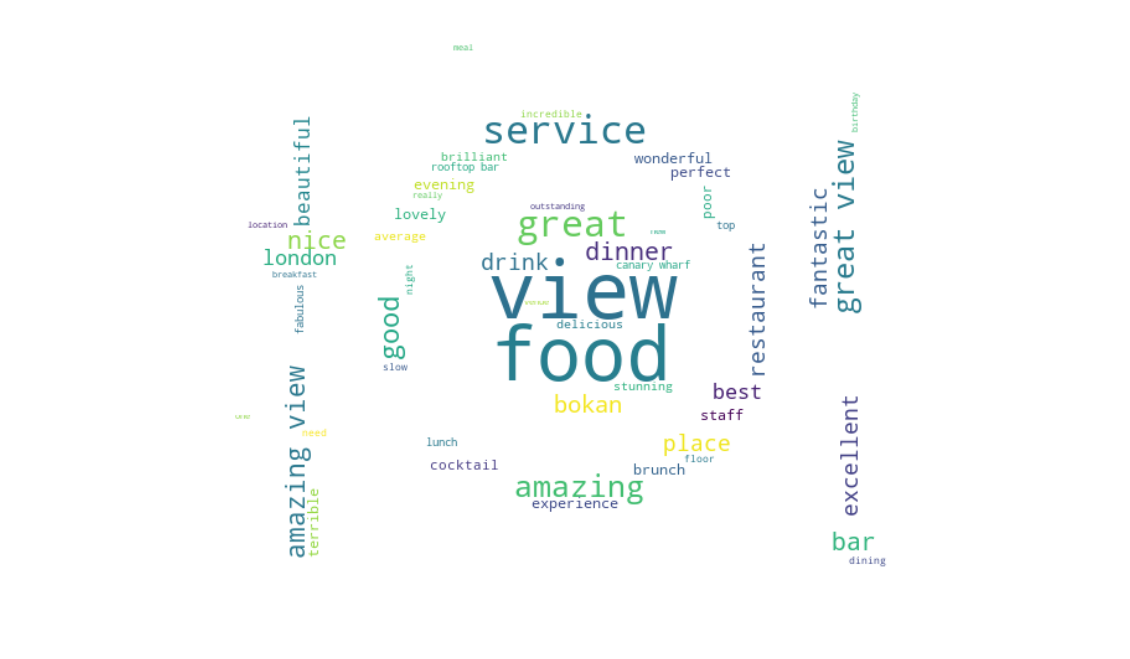

In [66]:
from_corpus_to_word_cloud(scrapped_data['clean_content'], plate_mask)

# Hands On 2 - Stemming and Lemmatization

## a) Stemming

    Stemming is the process of reducing inflection in words to their root forms such as mapping a group of words to the same stem even if the stem itself is not a valid word in the Language.

In [67]:
from nltk.stem.snowball import SnowballStemmer

# Function tho stem tokens using Porter Stemmer
def stem_review(tokens):
    porter = SnowballStemmer("english")
    #porter = PorterStemmer()
    return tokens.apply(lambda x: [porter.stem(x[i]) for i in range(len(x))])

In [68]:
stemmed_reviews = stem_review(tokenized_reviews)
stemmed_reviews. head()

0    [high, recommend, amaz, locat, best, chefsgrea...
1    [whaou, realli, realli, good, passion, good, g...
2    [site, decid, visit, share, starter, main, cou...
3    [brother, went, bokan, dinner, last, week, ill...
4    [went, dinner, partner, came, absolut, smitten...
Name: tokenized_content, dtype: object

In [69]:
temp = pd.DataFrame(['brother', 'went', 'bokan', 'dinner', 'last', 'week', 'ill', 'surely', 'return'])
flat_list = [item for sublist in stem_review(temp).values.tolist() for item in sublist]
print(flat_list)

['brother', 'went', 'bokan', 'dinner', 'last', 'week', 'ill', 'sure', 'return']


## b) Lemmatization

    Lemmatization, unlike Stemming, reduces the inflected words properly ensuring that the root word belongs to the language. In Lemmatization root word is called Lemma. A lemma (plural lemmas or lemmata) is the canonical form, dictionary form, or citation form of a set of words.

In [70]:
# Function tho lemmatize tokens using WordNetLemmatizer
def lemmatize_review(tokens):
    lemmatizer = WordNetLemmatizer()
    return tokens.apply(lambda x: [lemmatizer.lemmatize(x[i]) for i in range(len(x))])

In [102]:
lemmatized_reviews = lemmatize_review(tokenized_reviews)
lemmatized_reviews[1]

['whaou',
 'really',
 'really',
 'good',
 'passionned',
 'good',
 'gastromy',
 'france',
 'absolutely',
 'perfect',
 'view',
 'fantastic',
 'fabulous',
 'service',
 'nice',
 'always',
 'really',
 'perfect',
 'thanks',
 'moment',
 'fantastic',
 'better',
 'londonxa0']

In [72]:
flat_list_2 = [item for sublist in lemmatize_review(temp).values.tolist() for item in sublist]
print(flat_list_2)

['brother', 'went', 'bokan', 'dinner', 'last', 'week', 'ill', 'surely', 'return']


# Hands On 3

## Bag of Words

    The BOW model only considers if a known word occurs in a document or not. It does not care about meaning, context, and order in which they appear.
    This gives the insight that similar documents will have word counts similar to each other. In other words, the more similar the words in two documents, the more similar the documents can be.

In [73]:
# Let's first take a look at the most frequent words
word_frequency = Counter(chain(*tokenized_reviews)).most_common()
word_frequency

[('service', 307),
 ('bar', 285),
 ('views', 251),
 ('great', 250),
 ('staff', 249),
 ('view', 245),
 ('us', 208),
 ('table', 200),
 ('amazing', 197),
 ('drinks', 188),
 ('good', 187),
 ('bokan', 174),
 ('would', 173),
 ('place', 157),
 ('time', 151),
 ('one', 147),
 ('menu', 138),
 ('nice', 127),
 ('really', 126),
 ('floor', 117),
 ('go', 108),
 ('friendly', 106),
 ('night', 105),
 ('went', 104),
 ('well', 102),
 ('even', 99),
 ('dinner', 98),
 ('back', 98),
 ('cocktails', 95),
 ('definitely', 94),
 ('could', 94),
 ('best', 84),
 ('evening', 84),
 ('canary', 84),
 ('wharf', 84),
 ('wine', 83),
 ('recommend', 80),
 ('also', 79),
 ('excellent', 79),
 ('experience', 78),
 ('get', 78),
 ('didnt', 77),
 ('top', 74),
 ('visit', 72),
 ('like', 71),
 ('fantastic', 66),
 ('came', 65),
 ('asked', 65),
 ('made', 65),
 ('see', 63),
 ('novotel', 63),
 ('bit', 61),
 ('hotel', 61),
 ('make', 61),
 ('meal', 61),
 ('say', 58),
 ('much', 57),
 ('special', 55),
 ('however', 55),
 ('birthday', 54),
 ('to

In [97]:
# BOW using scikit-learn CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 1), analyzer = "word", stop_words = None, max_features = 10000) 
transformed_content = vectorizer.fit_transform(clean_reviews)

In [98]:
# Vocabulary of the BOW vectorizer
print(vectorizer.vocabulary_)
print(len(vectorizer.vocabulary_))

{'highly': 1867, 'recommend': 3039, 'the': 3754, 'food': 1594, 'most': 2449, 'amazing': 255, 'location': 2233, 'and': 275, 'best': 515, 'chefsgreat': 771, 'view': 4015, 'exciting': 1423, 'flavours': 1567, 'that': 3752, 'ive': 2069, 'never': 2503, 'tried': 3870, 'before': 494, 'went': 4126, 'with': 4182, 'my': 2474, 'friends': 1636, 'family': 1482, 'great': 1738, 'place': 2787, 'for': 1599, 'romantic': 3167, 'dinner': 1173, 'whaou': 4132, 'its': 2067, 'really': 3018, 'good': 1719, 'were': 4127, 'passionned': 2709, 'about': 135, 'gastromy': 1666, 'in': 1973, 'france': 1619, 'this': 3777, 'restaurant': 3113, 'absolutely': 140, 'perfect': 2737, 'is': 2054, 'fantastic': 1487, 'fabulous': 1464, 'service': 3306, 'so': 3435, 'nice': 2509, 'always': 250, 'again': 209, 'thanks': 3751, 'you': 4238, 'moment': 2436, 'better': 518, 'londonxa0': 2244, 'we': 4097, 'on': 2595, 'site': 3388, 'decided': 1082, 'to': 3813, 'visit': 4027, 'shared': 3327, 'few': 1523, 'starters': 3549, 'main': 2295, 'couple'

In [101]:
# Transformed content using BOW vectorizer
print(np.nonzero(transformed_content.toarray()[1]))

(array([ 135,  140,  209,  250,  275,  518, 1464, 1487, 1594, 1599, 1619,
       1666, 1719, 1973, 2054, 2067, 2244, 2436, 2509, 2709, 2737, 3018,
       3113, 3306, 3435, 3751, 3754, 3777, 4015, 4127, 4132, 4238]),)


In [100]:
print(transformed_content.shape)

(513, 4251)


## TFIDF

- One issue with simple counts is that some words like “the” will appear many times and their large counts will not be very meaningful in the encoded vectors.

- An alternative is to calculate word frequencies, and by far the most popular method is called TF-IDF. This is an acronym than stands for “Term Frequency – Inverse Document” Frequency which are the components of the resulting scores assigned to each word.

   **Term Frequency:** This summarizes how often a given word appears within a document.
   
   **Inverse Document Frequency:** This downscales words that appear a lot across documents

#### a) Built-in TFIDF

In [103]:
# TF-IDF using TfidfVectorizer from scikit-learn

from sklearn.feature_extraction.text import TfidfVectorizer
# create the transform
vectorizer = TfidfVectorizer()
# tokenize and build vocab
vectorizer.fit(clean_reviews)
# encode document
vector = vectorizer.transform(clean_reviews)

In [104]:
# Vocab of the vectorizer
print(vectorizer.vocabulary_)

{'highly': 1867, 'recommend': 3039, 'the': 3754, 'food': 1594, 'most': 2449, 'amazing': 255, 'location': 2233, 'and': 275, 'best': 515, 'chefsgreat': 771, 'view': 4015, 'exciting': 1423, 'flavours': 1567, 'that': 3752, 'ive': 2069, 'never': 2503, 'tried': 3870, 'before': 494, 'went': 4126, 'with': 4182, 'my': 2474, 'friends': 1636, 'family': 1482, 'great': 1738, 'place': 2787, 'for': 1599, 'romantic': 3167, 'dinner': 1173, 'whaou': 4132, 'its': 2067, 'really': 3018, 'good': 1719, 'were': 4127, 'passionned': 2709, 'about': 135, 'gastromy': 1666, 'in': 1973, 'france': 1619, 'this': 3777, 'restaurant': 3113, 'absolutely': 140, 'perfect': 2737, 'is': 2054, 'fantastic': 1487, 'fabulous': 1464, 'service': 3306, 'so': 3435, 'nice': 2509, 'always': 250, 'again': 209, 'thanks': 3751, 'you': 4238, 'moment': 2436, 'better': 518, 'londonxa0': 2244, 'we': 4097, 'on': 2595, 'site': 3388, 'decided': 1082, 'to': 3813, 'visit': 4027, 'shared': 3327, 'few': 1523, 'starters': 3549, 'main': 2295, 'couple'

In [105]:
print(vectorizer.idf_)

[6.14361098 6.54907608 6.54907608 ... 6.54907608 6.54907608 6.54907608]


In [107]:
# summarize encoded vector
print(vector.shape)
print(np.nonzero(vector.toarray()[1]))
print(vector.toarray()[1][np.nonzero(vector.toarray()[1])])

(513, 4251)
(array([ 135,  140,  209,  250,  275,  518, 1464, 1487, 1594, 1599, 1619,
       1666, 1719, 1973, 2054, 2067, 2244, 2436, 2509, 2709, 2737, 3018,
       3113, 3306, 3435, 3751, 3754, 3777, 4015, 4127, 4132, 4238]),)
[0.11975657 0.1458454  0.11109916 0.14995547 0.04084667 0.13985849
 0.15624309 0.23822633 0.06372706 0.05397626 0.23123462 0.24649561
 0.17371919 0.12658049 0.19206332 0.33485494 0.24649561 0.17065824
 0.10118459 0.24649561 0.26938896 0.30237141 0.16503363 0.06599056
 0.08852037 0.1458454  0.16275009 0.14633034 0.07205263 0.07114999
 0.24649561 0.07906134]
